## Imports

In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

## Regression

Mean Squared Error: 670503.1067098299
R-squared Score: 0.4273341379358818
Error: 818.8425408525316


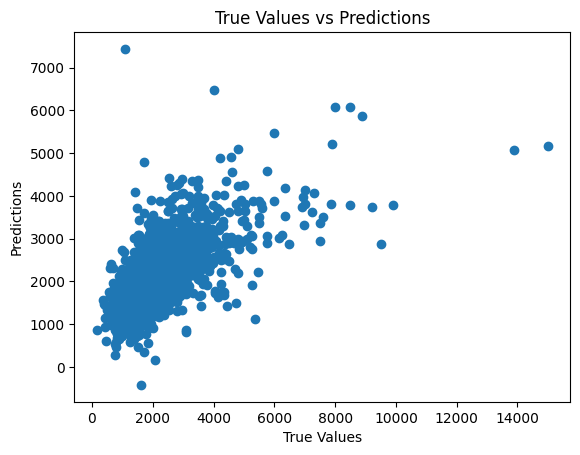

In [2]:
df = pd.read_csv("../preparation/flatfox_no_parking_clean.csv", low_memory=False)


X = df[["object_category","object_type","price_display_type","price_unit","number_of_rooms","floor","is_furnished","is_temporary","is_selling_furniture","zipcode", "city", "latitude","longitude","year_built","year_renovated","moving_date_type","reserved","livingspace"]] 

y = df["price_display"] 


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


# Initialize the model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred)}')
print(f'R-squared Score: {r2_score(y_test, y_pred)}')
print(f'Error: {np.sqrt(mean_squared_error(y_test, y_pred))}')



# Plot true vs predicted values
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs Predictions')
plt.show()

In [3]:
location_data = df[['latitude', 'longitude']]

# Define the number of clusters (you can adjust this number)
n_clusters = 1000
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
location_clusters = kmeans.fit_predict(location_data)

# Add the location clusters to the dataframe
df['location_cluster'] = location_clusters

## Random Forest
Removed: City, year_built, object_category, is_selling_furniture

C:\Users\lirla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Mean Squared Error: 285987.8739270309
R-squared Score: 0.7557423810219812
Error: 534.7783409292404


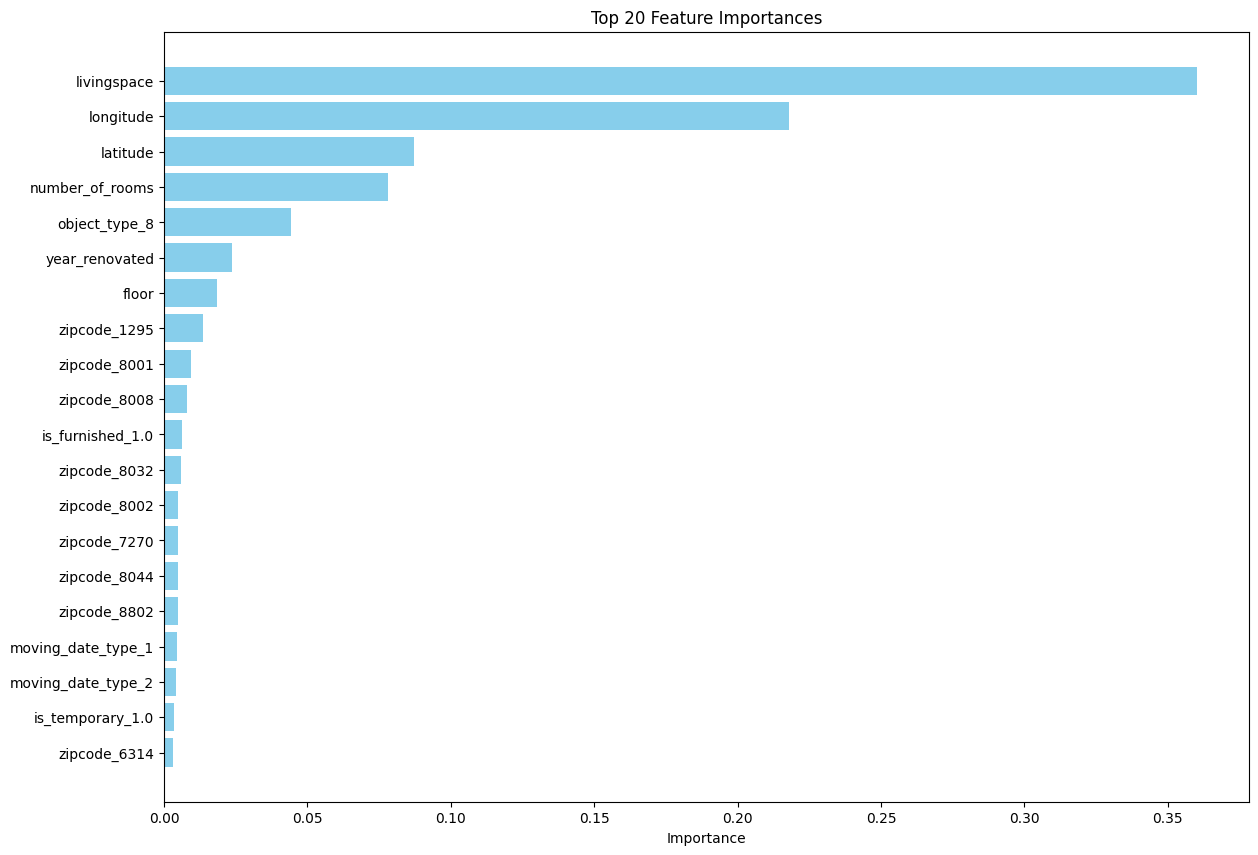

In [4]:
# Suppress specific warning
# Define features and target
X = df[["object_type","price_display_type","price_unit","number_of_rooms","floor","is_furnished","is_temporary","zipcode","latitude","longitude","year_renovated","moving_date_type","reserved","livingspace"]]

y = df["price_display"]

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['price_unit', 'number_of_rooms', 'floor', 'latitude', 'longitude', 'year_renovated', 'reserved', 'livingspace']),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), ['object_type', 'price_display_type', 'zipcode', 'moving_date_type', 'is_furnished', 'is_temporary'])
    ])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Create and train the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=0))
])
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred)}')
print(f'R-squared Score: {r2_score(y_test, y_pred)}')
print(f'Error: {np.sqrt(mean_squared_error(y_test, y_pred))}')


# Extract feature importances
feature_importances = pipeline.named_steps['model'].feature_importances_

# Extract feature names
num_features = preprocessor.transformers_[0][2]
cat_features = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(['object_type', 'price_display_type', 'zipcode', 'moving_date_type', 'is_furnished', 'is_temporary'])
all_features = np.concatenate([num_features, cat_features])

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': all_features, 'Importance': feature_importances})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Limit the number of features shown for better readability (e.g., top 20 features)
top_n = 20
top_features = feature_importance_df.head(top_n)

# Plot the feature importances
plt.figure(figsize=(14, 10))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title(f'Top {top_n} Feature Importances')
plt.gca().invert_yaxis()
plt.show()


Error: 534.7783409292404

## Random Forest Hyper Parameter Tuning

Best Parameters: {'model__n_estimators': 100, 'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_depth': None}
Best R-squared Score from CV: 0.7170982704660549
Mean Squared Error: 315317.5168879318
R-squared Score: 0.7306924072005985
Error: 561.5314032963176


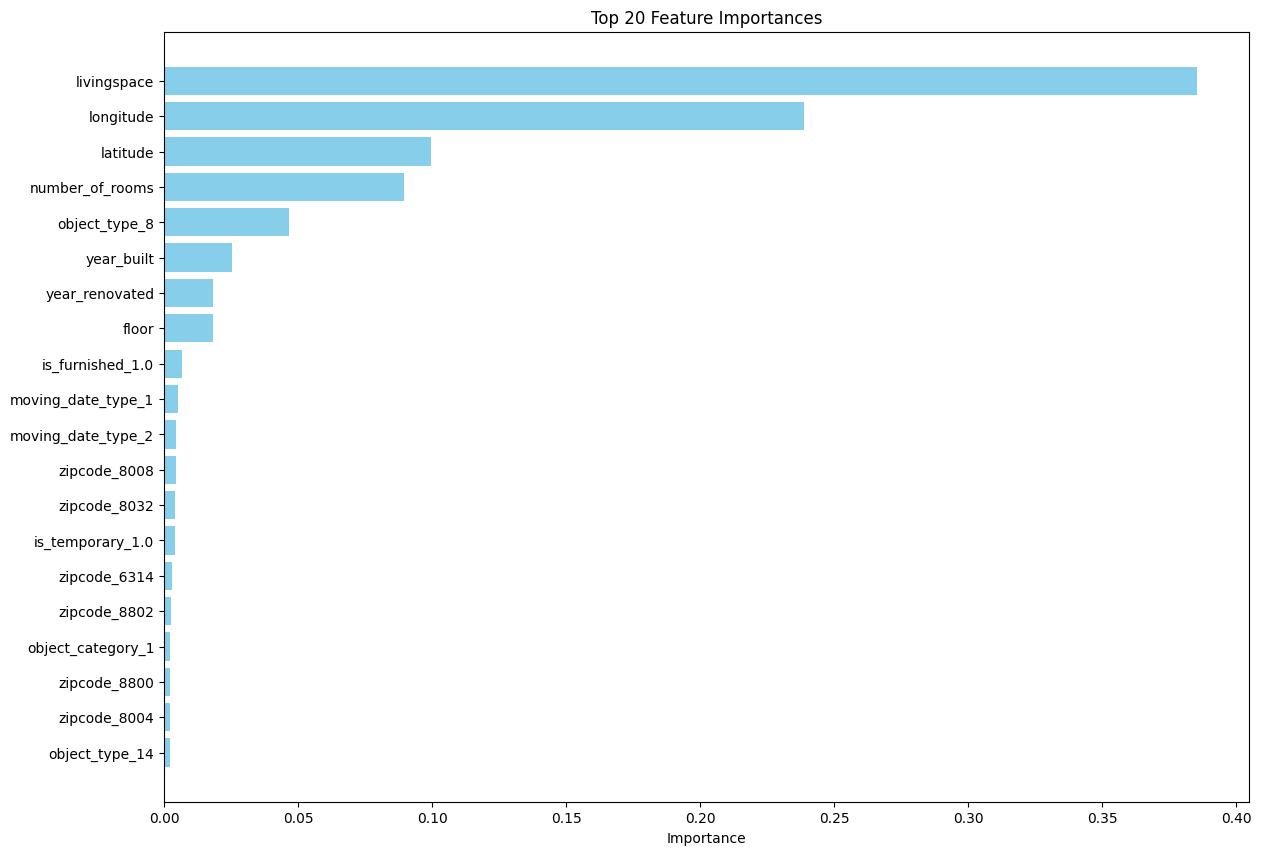

In [48]:
# Suppress specific warning
warnings.filterwarnings(action='ignore', category=UserWarning, module='sklearn.preprocessing._encoders')

# Define features and target
X = df[["object_category","object_type","price_display_type","price_unit","number_of_rooms","floor","is_furnished","is_temporary","is_selling_furniture","zipcode","latitude","longitude","year_built","year_renovated","moving_date_type","reserved","livingspace"]]
y = df["price_display"]

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['price_unit', 'number_of_rooms', 'floor', 'latitude', 'longitude', 'year_built', 'year_renovated', 'reserved', 'livingspace']),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), ['object_category', 'object_type', 'price_display_type', 'zipcode', 'moving_date_type', 'is_furnished', 'is_temporary', 'is_selling_furniture'])
    ])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=0))
])

# Define the parameter distribution
param_distributions = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# Instantiate RandomizedSearchCV
random_search = RandomizedSearchCV(pipeline, param_distributions, n_iter=50, cv=5, n_jobs=-1, scoring='r2', random_state=0)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = random_search.best_params_
best_score = random_search.best_score_

print(f'Best Parameters: {best_params}')
print(f'Best R-squared Score from CV: {best_score}')

# Make predictions with the best estimator
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the best model
print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred)}')
print(f'R-squared Score: {r2_score(y_test, y_pred)}')
print(f'Error: {np.sqrt(mean_squared_error(y_test, y_pred))}')

# Extract feature importances
feature_importances = best_model.named_steps['model'].feature_importances_

# Extract feature names
num_features = preprocessor.transformers[0][2]
cat_features = best_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(['object_category', 'object_type', 'price_display_type', 'zipcode', 'moving_date_type', 'is_furnished', 'is_temporary', 'is_selling_furniture'])
all_features = np.concatenate([num_features, cat_features])

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': all_features, 'Importance': feature_importances})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Limit the number of features shown for better readability (e.g., top 20 features)
top_n = 20
top_features = feature_importance_df.head(top_n)

# Plot the feature importances
plt.figure(figsize=(14, 10))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title(f'Top {top_n} Feature Importances')
plt.gca().invert_yaxis()
plt.show()

## XGBoost
Removed: City, year_built, object_category, is_selling_furniture

(pray to the Omnissiah) this works, 16/9 will provide us assistance

In [9]:
# Suppress specific warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='xgboost')

# Define features and target
X = df[["object_type","price_display_type","price_unit","number_of_rooms","floor","is_furnished","is_temporary","zipcode","latitude","longitude","year_renovated","moving_date_type","reserved","livingspace"]]
y = df["price_display"]

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['price_unit', 'number_of_rooms', 'floor', 'latitude', 'longitude', 'year_renovated', 'reserved', 'livingspace']),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), ['object_type', 'price_display_type', 'zipcode', 'moving_date_type', 'is_furnished', 'is_temporary'])
    ])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Create and train the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(n_estimators=200, random_state=5))
])
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred)}')
print(f'R-squared Score: {r2_score(y_test, y_pred)}')
print(f'Error: {np.sqrt(mean_squared_error(y_test, y_pred))}')

Mean Squared Error: 292400.20030385535
R-squared Score: 0.7502657167445556
Error: 540.740418596442


C:\Users\lirla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


## XGBoost Hyper Parameter Tuning
Removed: City, year_built, object_category, is_selling_furniture


In [21]:
from sklearn.model_selection import GridSearchCV
# Suppress specific warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='xgboost')

# Define features and target
X = df[["object_type","number_of_rooms","floor","is_furnished","is_temporary","zipcode","latitude","longitude","year_renovated","moving_date_type","livingspace"]]
y = df["price_display"]

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['number_of_rooms', 'floor', 'latitude', 'longitude', 'year_renovated','livingspace']),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), ['object_type', 'zipcode', 'moving_date_type', 'is_furnished', 'is_temporary'])
    ])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(random_state=0))
])

vals = np.linspace(0.01, 0.2, 20)

# Define parameter grid
param_grid = {
    'model__n_estimators': [400],
    'model__max_depth': [7],
    'model__learning_rate': [0.1],
    'model__subsample': [0.7],
    'model__colsample_bytree': [0.8]
}

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=7, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best parameters
print(f'Best parameters: {grid_search.best_params_}')

# Make predictions with the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the model
print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred)}')
print(f'R-squared Score: {r2_score(y_test, y_pred)}')
print(f'Error: {np.sqrt(mean_squared_error(y_test, y_pred))}')

test_flat = {
    "object_category": [0],
    "object_type": [8],
    "price_display": [3100],
    "price_display_type": [1],
    "price_unit": [0],
    "number_of_rooms": [2],
    "floor": [0],
    "is_furnished": [1],
    "is_temporary": [0],
    "is_selling_furniture": [0],
    "zipcode": [8003],
    "city": [1746],
    "latitude": [47.36764161],
    "longitude": [8.521921235],
    "year_built": [39.47986307],
    "year_renovated": [7],
    "moving_date_type": [2],
    "reserved": [0],
    "livingspace": [60]
}

test_pred = best_model.predict(pd.DataFrame(test_flat))
print(test_pred)


Best parameters: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 400, 'model__subsample': 0.7}
Mean Squared Error: 261073.6346950472
R-squared Score: 0.7770212299112379
Error: 510.9536521985602
[3373.5942]


C:\Users\lirla\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
Best parameters: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 400, 'model__subsample': 0.7}
Mean Squared Error: 250534.30200750157
R-squared Score: 0.7860227035490116
Error: 500.5340168335231


In [123]:
vals = np.linspace(0.01, 0.2, 20)
print(vals)

[0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2 ]


In [119]:
print(np.float64(0.11))

0.11
